In [1]:
import zipfile
with zipfile.ZipFile('/content/Дополнительные материалы-20250331.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [2]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from pickle import dump

In [1]:
import os

import numpy as np
import pandas as pd


class ClearDataFrames:
    def __init__(self):
        self.customers = pd.read_csv('hackathon/customers.csv')
        self.geolocation = pd.read_csv('hackathon/geolocation.csv')
        self.order_payments = pd.read_csv('hackathon/order_payments.csv')
        self.order_reviews = pd.read_csv('hackathon/order_reviews.csv')
        self.orders = pd.read_csv('hackathon/orders.csv')
        self.orders_items = pd.read_csv('hackathon/orders_items.csv')
        self.product_category_name_translation = pd.read_csv('hackathon/product_category_name_translation.csv')
        self.products = pd.read_csv('hackathon/products.csv')
        self.sellers = pd.read_csv('hackathon/sellers.csv')

    def clear_data(self):
        self.__clear_products()
        self.__clear_reviews()
        self.__clear_payments()
        self.__clear_orders()
        self.__clear_orders_items()
        self.__clear_geolocation()
        self.__clear_product_category_name_translation()
        self.__clear_sellers()

    def __clear_products(self):
        indices_to_drop = self.products[
            ~self.products['product_category_name'].isin(self.product_category_name_translation['product_category_name'])].index
        self.products.drop(indices_to_drop, inplace=True)
        self.products.rename(columns={
            'product_name_lenght': 'product_name_length',
            'product_description_lenght': 'product_description_length'
        }, inplace=True)
        self.products.dropna(inplace=True)

    def __clear_reviews(self):
        self.order_reviews.drop(columns=['Unnamed: 0'], inplace=True)

    def __clear_payments(self):
        self.order_payments.drop(columns=['Unnamed: 0'], inplace=True)
        self.order_payments.drop_duplicates(inplace=True)

    def __clear_geolocation(self):
        used_zip_codes = pd.concat([
            self.sellers['seller_zip_code_prefix'],
            self.customers['customer_zip_code_prefix']
        ]).drop_duplicates()

        mask = ~self.geolocation['geolocation_zip_code_prefix'].isin(used_zip_codes)

        self.geolocation = self.geolocation[~mask].copy()
        self.geolocation.drop_duplicates(inplace=True)
        self.geolocation.drop(columns=['Unnamed: 0'], inplace=True)

        def calc_most_state(group):
            res_group = pd.Series({
                'most_state': group['geolocation_state'].value_counts().index[0],
            })
            return res_group

        geolocation_states = (self.geolocation.groupby('geolocation_zip_code_prefix')[['geolocation_state']]
                              .apply(calc_most_state).reset_index())
        self.geolocation = pd.merge(self.geolocation, geolocation_states, on='geolocation_zip_code_prefix', how='left')
        self.geolocation['geolocation_state'] = (self.geolocation['most_state']
                                                 .combine_first(self.geolocation['geolocation_state']))
        self.geolocation.drop(columns=['most_state'], inplace=True)
        q_percent = 0.25

        def find_outliers(group):
            if len(group) >= 2:
                # latitude
                group_unique = group.drop_duplicates(subset=['geolocation_lat', 'geolocation_lng'])
                lats = group['geolocation_lat']
                Q1 = np.quantile(lats, q_percent)
                Q3 = np.quantile(lats, 1 - q_percent)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                group = group[
                    (group['geolocation_lat'] >= lower_bound) &
                    (group['geolocation_lat'] <= upper_bound)
                    ]

                # longitude
                lngs = group['geolocation_lng']
                Q1 = np.quantile(lngs, q_percent)
                Q3 = np.quantile(lngs, 1 - q_percent)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                group = group[
                    (group['geolocation_lng'] >= lower_bound) &
                    (group['geolocation_lng'] <= upper_bound)
                    ]
                return group
            return group

        # self.geolocation = self.geolocation.groupby('geolocation_state').apply(find_outliers).reset_index(drop=True)
        self.geolocation = self.geolocation.groupby('geolocation_zip_code_prefix').apply(find_outliers).reset_index(drop=True)

    def __clear_orders(self):
        delivered = self.orders[self.orders['order_status'] == 'delivered']
        drop_i = delivered[delivered.isna().any(axis=1)].index  # delivered orders with NaN timestamps
        self.orders.drop(index=drop_i, inplace=True)
        self.orders.drop_duplicates(inplace=True)

    def __clear_orders_items(self):
        try:
            self.orders_items.drop(['freight_value.1', 'shipping_limit_date.1', 'price.1'], axis=1, inplace=True)
        except Exception:
            pass

        indices_to_drop = self.orders_items[~self.orders_items['order_id'].isin(self.orders['order_id'])].index
        self.orders_items.drop(indices_to_drop, inplace=True)

        indices_to_drop = self.orders_items[~self.orders_items['product_id'].isin(self.products['product_id'])].index
        self.orders_items.drop(indices_to_drop, inplace=True)

        self.orders_items.drop(columns=['Unnamed: 0'], inplace=True)

    def __clear_product_category_name_translation(self):
        self.product_category_name_translation.drop(columns=['Unnamed: 0'], inplace=True)

    def __clear_sellers(self):
        self.sellers.drop(columns=['Unnamed: 0'], inplace=True)

In [2]:
data = ClearDataFrames()
data.clear_data()

<ipython-input-1-3fd1884486d5>:14: DtypeWarning: Columns (1,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  self.orders_items = pd.read_csv('hackathon/orders_items.csv')
<ipython-input-1-3fd1884486d5>:102: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.geolocation = self.geolocation.groupby('geolocation_zip_code_prefix').apply(find_outliers).reset_index(drop=True)


In [3]:
days_th = 231
max_date = data.orders['order_purchase_timestamp'].map(lambda x: pd.Timestamp(x)).max()

In [76]:
def compile_data_to_one_place(data):
  dataset = data.orders.copy()
  dataset = dataset.merge(data.customers.drop(columns=['customer_zip_code_prefix', 'customer_city', 'customer_state']), on='customer_id').drop(columns=['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
  dataset = dataset[~dataset['order_status'].isin(['unavailable', 'canceled'])]
  dataset = dataset.drop(columns=['order_status'])
  dataset['order_purchase_timestamp'] = dataset['order_purchase_timestamp'].map(lambda x: pd.Timestamp(x))
  dataset = dataset.merge(data.order_reviews[['order_id', 'review_score']], on='order_id', how='left')
  mean_score = dataset['review_score'].dropna().values.mean()
  dataset.fillna({'review_score': mean_score}, inplace=True)
  dataset = dataset.merge(data.order_payments.drop_duplicates(subset=['order_id'])[['order_id', 'payment_value']], on='order_id').drop(columns=['customer_id', 'order_id'])
  return dataset

In [77]:
def compile_info_about_customer(customer):
  rows = customer.shape[0]
  info = {
        'orders_count': rows,
        'last_score': customer.iloc[-1]['review_score'],
        'last_payment': customer.iloc[-1]['payment_value'],
        'last_days_between_orders': (customer.iloc[-1]['order_purchase_timestamp'] - customer.iloc[-2]['order_purchase_timestamp']).days if rows > 1 else np.nan, # rows > 1?
        'mean_score': customer.iloc[0:-1]['review_score'].mean() if rows > 1 else np.nan, # rows > 1?
        'mean_payment': customer.iloc[0:-1]['payment_value'].mean() if rows > 1 else np.nan, # rows > 1?
        'mean_days_between_orders': (customer.iloc[-2]['order_purchase_timestamp'] - customer.iloc[0]['order_purchase_timestamp']).days * 1.0 / (rows - 2) if rows > 2 else np.nan # rows > 2?
        }
  return info

In [78]:
def create_dataset(data, max_date, should_expand_dataset=True, keep_1_orders_customers = None, keep_fields_with_1_order = True, target_days_th = None):
  dataset = compile_data_to_one_place(data)
  if keep_1_orders_customers is not None:
    tmp = dataset.groupby('customer_unique_id').count().reset_index()
    id_with_1_order = tmp[tmp['review_score'] == 1]['customer_unique_id'].values   # dataset['review_score'] | we can use any column because they are same
    rng = np.random.default_rng(1)
    id_with_1_order = rng.choice(id_with_1_order, keep_1_orders_customers, replace=False)
    id_with_ge2_orders = tmp[tmp['review_score'] > 1]['customer_unique_id'].values # dataset['review_score'] | we can use any column because they are same
    ids = np.concat((id_with_1_order, id_with_ge2_orders))
    dataset = dataset[dataset['customer_unique_id'].isin(ids)]

  expand_dataset = pd.DataFrame()

  for id, group in dataset.groupby('customer_unique_id'):
    group = group.sort_values(by='order_purchase_timestamp')
    for i in range(group.shape[0]) if should_expand_dataset else [group.shape[0] - 1]:
      row = compile_info_about_customer(group.iloc[0:i + 1])
      row['customer_unique_id'] = id
      row['days_after_order'] = (max_date - group.iloc[i]['order_purchase_timestamp']).days
      if target_days_th:
        row['retention'] = 0 if i == group.shape[0] - 1 and (max_date - group.iloc[i]['order_purchase_timestamp']).days >= target_days_th else 1

      if expand_dataset.shape[0] == 0:
          expand_dataset = pd.DataFrame(columns=row)
      expand_dataset.loc[len(expand_dataset)] = row

  if not keep_fields_with_1_order:
    expand_dataset = expand_dataset[expand_dataset['orders_count'] > 1]

  return expand_dataset

In [79]:
d = create_dataset(data, max_date, should_expand_dataset=False, keep_1_orders_customers=0, keep_fields_with_1_order=True, target_days_th=days_th)

In [81]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2971 entries, 0 to 2970
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   orders_count              2971 non-null   int64  
 1   last_score                2971 non-null   float64
 2   last_payment              2971 non-null   float64
 3   last_days_between_orders  2971 non-null   int64  
 4   mean_score                2971 non-null   float64
 5   mean_payment              2971 non-null   float64
 6   mean_days_between_orders  548 non-null    float64
 7   customer_unique_id        2971 non-null   object 
 8   days_after_order          2971 non-null   int64  
 9   retention                 2971 non-null   int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 255.3+ KB


In [82]:
d.groupby('retention').count()

,orders_count,last_score,last_payment,last_days_between_orders,mean_score,mean_payment,mean_days_between_orders,customer_unique_id,days_after_order
retention,,,,,,,,,
0,1676,1676,1676,1676,1676,1676,362,1676,1676
1,1295,1295,1295,1295,1295,1295,186,1295,1295


In [83]:
split_num = 4
group_kfold = GroupKFold(n_splits=split_num, random_state=1, shuffle=True)
splits = group_kfold.split(d.drop(columns=['retention']), d['retention'], d['customer_unique_id'])
(train, test) = next(splits)
train_X, train_y = d.iloc[train].drop(columns=['retention', 'customer_unique_id']), d.iloc[train]['retention']

group_kfold = GroupKFold(n_splits=2, random_state=1, shuffle=True)
splits = group_kfold.split(d.iloc[test].drop(columns=['retention']), d.iloc[test]['retention'], d.iloc[test]['customer_unique_id'])
(valid, test) = next(splits)
valid_X, valid_y = d.iloc[valid].drop(columns=['retention', 'customer_unique_id']), d.iloc[valid]['retention']
test_X, test_y = d.iloc[test].drop(columns=['retention', 'customer_unique_id']), d.iloc[test]['retention']

In [84]:
train_X.shape, valid_X.shape, test_X.shape

((2228, 8), (371, 8), (372, 8))

# Random Forest

In [89]:
model = RandomForestClassifier(random_state=1)
model.fit(train_X.drop(columns=['days_after_order']), train_y)

RandomForestClassifier(random_state=1)

In [90]:
model.score(valid_X.drop(columns=['days_after_order']), valid_y)

0.9164420485175202

In [91]:
with open("sub_rfc.pkl", "wb") as f:
    dump(model, f, protocol=5)

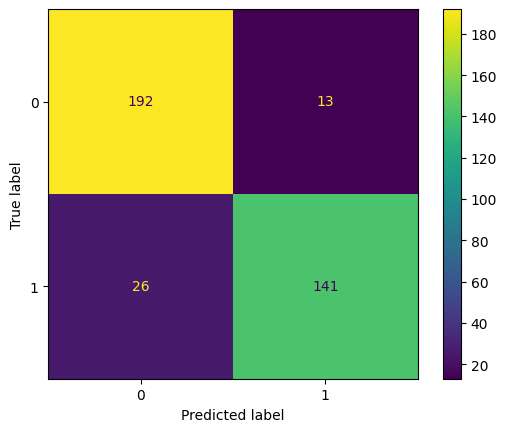

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_y, model.predict(test_X.drop(columns=['days_after_order'])), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model2 = GradientBoostingClassifier(random_state=0)
model2.fit(train_X.drop(columns=['mean_days_between_orders', 'date']), train_y)
model2.score(valid_X.drop(columns=['mean_days_between_orders', 'date']), valid_y)

0.6453781512605042

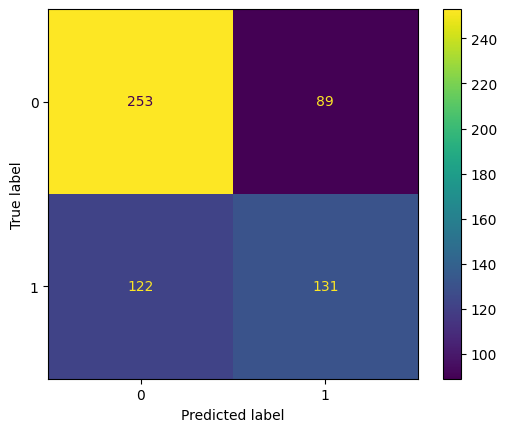

In [ ]:
cm = confusion_matrix(test_y, model2.predict(test_X.drop(columns=['mean_days_between_orders', 'date'])), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

# Regression for customers with > 1 orders

In [101]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

reg_dataset = pd.DataFrame(columns=['days_after_order', 'rfc'])
reg_dataset['days_after_order'] = valid_X['days_after_order']
reg_dataset['rfc'] = model.predict_proba(valid_X.drop(columns=['days_after_order']))[:,1]

reg_dataset_test = pd.DataFrame(columns=['days_after_order', 'rfc'])
reg_dataset_test['days_after_order'] = test_X['days_after_order']
reg_dataset_test['rfc'] = model.predict_proba(test_X.drop(columns=['days_after_order']))[:,1]


pipeline_model = make_pipeline(StandardScaler(),
                               LogisticRegression())

pipeline_model.fit(reg_dataset, valid_y)
pipeline_model.score(reg_dataset_test, test_y)

0.9838709677419355

In [103]:
with open("models/model_for_several_orders.pkl", "wb") as f:
    dump(pipeline_model, f, protocol=5)

# Regression for customers with 1 order

In [118]:
explicit_dataset = compile_data_to_one_place(data)
tmp = explicit_dataset.groupby('customer_unique_id').count().reset_index()
id_with_1_order = tmp[tmp['review_score'] == 1]['customer_unique_id'].values
explicit_dataset = explicit_dataset[explicit_dataset['customer_unique_id'].isin(id_with_1_order)].drop(columns=['customer_unique_id'])
explicit_dataset['days_after_order'] = (max_date - explicit_dataset['order_purchase_timestamp']).map(lambda x: x.days)
explicit_dataset.drop(columns=['order_purchase_timestamp'], inplace=True)
explicit_dataset['retention'] = explicit_dataset['days_after_order'].map(lambda x: 0 if x >= days_th else 1)
explicit_dataset

,review_score,payment_value,days_after_order,retention
1,4.0,141.46,84,1
2,5.0,179.12,70,1
3,5.0,72.20,332,0
4,5.0,28.62,245,0
5,4.0,175.26,464,0
...,...,...,...,...
98723,5.0,85.08,587,0
98724,4.0,195.00,253,0
98725,5.0,271.01,416,0
98726,2.0,441.16,281,0


In [119]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
o1_X_train, o1_X_test, o1_y_train, o1_y_test = train_test_split(explicit_dataset.drop(columns=['retention']), explicit_dataset['retention'], test_size=0.2, random_state=1)

o1_pipeline_model = make_pipeline(StandardScaler(),
                                  LogisticRegression())

o1_pipeline_model.fit(o1_X_train, o1_y_train)
o1_pipeline_model.score(o1_X_test, o1_y_test)

0.9998369565217391

In [120]:
with open("models/model_for_1_order.pkl", "wb") as f:
    dump(o1_pipeline_model, f, protocol=5)

In [39]:
o1_pipeline_model.predict_proba(o1_X_test.iloc[20].to_frame().T)

array([[3.56724738e-08, 9.99999964e-01]])

In [38]:
o1_pipeline_model.get_params()['logisticregression'].coef_

array([[-4.73459182e-02,  2.34480648e-02, -3.53068338e+01]])

# Model

### Several orders

In [134]:
def prepare_data_for_several_order_model(compiled_data, current_date):
  tmp = compiled_data.groupby('customer_unique_id').count().reset_index()
  id_with_ge2_orders = tmp[tmp['review_score'] > 1]['customer_unique_id'].values # dataset['review_score'] | we can use any column because they are same
  tmp_data = compiled_data[compiled_data['customer_unique_id'].isin(id_with_ge2_orders)]
  data = pd.DataFrame()

  for _, group in tmp_data.groupby('customer_unique_id'):
    group = group.sort_values(by='order_purchase_timestamp')
    i = group.shape[0] - 1
    row = compile_info_about_customer(group)
    row['days_after_order'] = (current_date - group.iloc[-1]['order_purchase_timestamp']).days

    if data.shape[0] == 0:
        data = pd.DataFrame(columns=row)
    data.loc[len(data)] = row

  return data

In [131]:
from pathlib import Path
from pickle import load

class SeveralOrdersModel:
  def __init__(self, models_dir=""):
    with open(Path(models_dir) / Path("sub_rfc.pkl"), "rb") as f:
        self.sub_rfc = load(f)
    with open(Path(models_dir) / Path("models/model_for_several_orders.pkl"), "rb") as f:
        self.several_orders_model = load(f)

  def predict(self, X):
    interim_data = pd.DataFrame(columns=['days_after_order', 'rfc'])
    interim_data['days_after_order'] = X['days_after_order']
    interim_data['rfc'] = self.sub_rfc.predict_proba(X.drop(columns=['days_after_order']))[:,1]
    preds = self.several_orders_model.predict(interim_data)
    return preds

  def predict_proba(self, X):
    interim_data = pd.DataFrame(columns=['days_after_order', 'rfc'])
    interim_data['days_after_order'] = X['days_after_order']
    interim_data['rfc'] = self.sub_rfc.predict_proba(X.drop(columns=['days_after_order']))[:,1]
    probas = self.several_orders_model.predict_proba(interim_data)[:, 1]
    return probas

In [135]:
m = SeveralOrdersModel()
test_data = prepare_data_for_several_order_model(compile_data_to_one_place(data), max_date)
display(test_data)
m.predict(test_data)

,orders_count,last_score,last_payment,last_days_between_orders,mean_score,mean_payment,mean_days_between_orders,days_after_order
0,2,4.0,46.85,0,5.000000,46.850000,NaN,383
1,2,5.0,103.28,170,5.000000,251.090000,NaN,276
2,2,5.0,49.85,267,1.000000,97.870000,NaN,143
3,2,4.0,26.78,10,4.000000,96.470000,NaN,136
4,4,3.0,81.78,0,4.333333,56.873333,0.0,574
...,...,...,...,...,...,...,...,...
2966,2,1.0,166.46,9,1.000000,166.460000,NaN,44
2967,2,3.0,0.53,0,3.000000,0.720000,NaN,515
2968,3,1.0,66.74,0,3.500000,165.070000,186.0,324
2969,3,5.0,42.58,22,4.000000,48.510000,182.0,398


array([0, 0, 1, ..., 0, 0, 0])

### One order

In [126]:
def prepare_data_for_one_order_model(compiled_data, max_date):
  tmp = compiled_data.groupby('customer_unique_id').count().reset_index()
  id_with_1_order = tmp[tmp['review_score'] == 1]['customer_unique_id'].values
  data = compiled_data[compiled_data['customer_unique_id'].isin(id_with_1_order)].drop(columns=['customer_unique_id']).copy()
  data['days_after_order'] = (max_date - data['order_purchase_timestamp']).map(lambda x: x.days)
  data = data[['review_score', 'payment_value', 'days_after_order']]
  return data

In [73]:
class OneOrderModel:
  def __init__(self, model_dir=""):
    with open(Path(model_dir) / Path("models/model_for_1_order.pkl"), "rb") as f:
        self.one_order_model = load(f)

  def predict(self, X):
    return  self.one_order_model.predict(X)

  def predict_proba(self, X):
    return self.one_order_model.predict_proba(X)[:, 1]


In [127]:
m = OneOrderModel()
test_data = prepare_data_for_one_order_model(compile_data_to_one_place(data), max_date)
display(test_data)
m.predict(test_data)

,review_score,payment_value,days_after_order
1,4.0,141.46,84
2,5.0,179.12,70
3,5.0,72.20,332
4,5.0,28.62,245
5,4.0,175.26,464
...,...,...,...
98723,5.0,85.08,587
98724,4.0,195.00,253
98725,5.0,271.01,416
98726,2.0,441.16,281


array([1, 1, 0, ..., 0, 0, 1])